In [ ]:
print("hello")

hello


In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20

# directory containing the UCF50 dataset.
DATASET_DIR = "dataset/UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
# CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]


# CLASSES_LIST = ["BaseballPitch",  "Diving",       "HulaHoop",       "MilitaryParade",  "PlayingViolin",       "RopeClimbing",    "Swing",              "WalkingWithDog",
# "Basketball",     "Drumming",     "JavelinThrow",   "Mixing",          "PoleVault",           "Rowing",          "TaiChi",             "YoYo",
# "BenchPress",     "Fencing",      "JugglingBalls",  "Nunchucks",       "PommelHorse",         "SalsaSpin",       "TennisSwing",
# "Biking",         "GolfSwing",    "JumpingJack",    "PizzaTossing",    "PullUps",             "SkateBoarding",   "ThrowDiscus",
# "Billiards",      "HighJump",     "JumpRope",       "PlayingGuitar",   "Punch",               "Skiing",
# "BreastStroke",   "HorseRace",   "Kayaking",       "PlayingPiano",    "PushUps",            "Skijet",          "TrampolineJumping",
# "CleanAndJerk",   "HorseRiding",  "Lunges",         "PlayingTabla",    "RockClimbingIndoor",  "SoccerJuggling", "VolleyballSpiking"]

CLASSES_LIST = ["BaseballPitch",  "Diving",       "HulaHoop",       "MilitaryParade",  "PlayingViolin",       "RopeClimbing",    "Swing",              "WalkingWithDog",
"Basketball",     "Drumming",     "JavelinThrow",   "Mixing",          "PoleVault",           "Rowing",          "TaiChi",             "YoYo",
"BenchPress",     "Fencing",      "JugglingBalls",  "Nunchucks",       "PommelHorse",         "SalsaSpin",       "TennisSwing",
"Biking",         "GolfSwing",    "JumpingJack",    "PizzaTossing" ]

In [ ]:
def frames_extraction(video_path):
    # Declare a list to store video frames.
    frames_list = []

    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: BaseballPitch
Extracting Data of Class: Diving
Extracting Data of Class: HulaHoop
Extracting Data of Class: MilitaryParade
Extracting Data of Class: PlayingViolin
Extracting Data of Class: RopeClimbing
Extracting Data of Class: Swing
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: Basketball
Extracting Data of Class: Drumming
Extracting Data of Class: JavelinThrow
Extracting Data of Class: Mixing
Extracting Data of Class: PoleVault
Extracting Data of Class: Rowing
Extracting Data of Class: TaiChi
Extracting Data of Class: YoYo
Extracting Data of Class: BenchPress
Extracting Data of Class: Fencing
Extracting Data of Class: JugglingBalls
Extracting Data of Class: Nunchucks
Extracting Data of Class: PommelHorse
Extracting Data of Class: SalsaSpin
Extracting Data of Class: TennisSwing
Extracting Data of Class: Biking
Extracting Data of Class: GolfSwing
Extracting Data of Class: JumpingJack
Extracting Data of Class: PizzaTossing


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def create_convlstm_model():

    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    model.summary()

    return model

In [ ]:

convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed_24 (TimeDi  (None, 20, 31, 31, 4)    0         
 stributed)                                                      
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                      

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2)

Epoch 1/50
543/543 [==============================] - 239s 429ms/step - loss: 2.9467 - accuracy: 0.1397 - val_loss: 2.4533 - val_accuracy: 0.2891
Epoch 2/50
543/543 [==============================] - 233s 429ms/step - loss: 2.2968 - accuracy: 0.3204 - val_loss: 2.0587 - val_accuracy: 0.4217
Epoch 3/50
543/543 [==============================] - 233s 428ms/step - loss: 1.7258 - accuracy: 0.4790 - val_loss: 1.7711 - val_accuracy: 0.4622
Epoch 4/50
543/543 [==============================] - 232s 427ms/step - loss: 1.2815 - accuracy: 0.6150 - val_loss: 1.5695 - val_accuracy: 0.5635
Epoch 5/50
543/543 [==============================] - 232s 428ms/step - loss: 0.9213 - accuracy: 0.7206 - val_loss: 1.5262 - val_accuracy: 0.5801
Epoch 6/50
543/543 [==============================] - 232s 427ms/step - loss: 0.7372 - accuracy: 0.7676 - val_loss: 1.4178 - val_accuracy: 0.6280
Epoch 7/50
543/543 [==============================] - 232s 427ms/step - loss: 0.5245 - accuracy: 0.8368 - val_loss: 1.3669 -

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

29/29 [==============================] - 12s 416ms/step - loss: 2.3268 - accuracy: 0.6947


In [ ]:

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

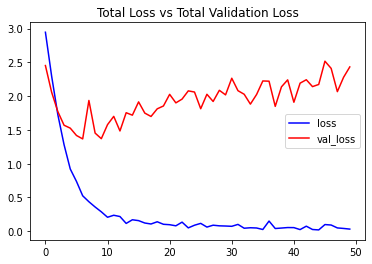

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

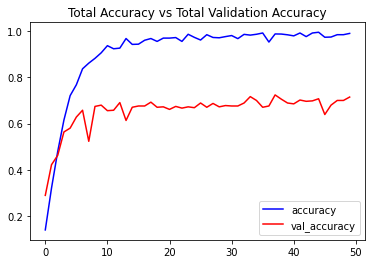

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')